<a href="https://colab.research.google.com/github/heejeongJ/DL_pt/blob/Autoencoder-%234/Autoencoder_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9912422/9912422 [00:00<00:00, 131231077.15it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47676732.04it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5604745.15it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

cuda:0


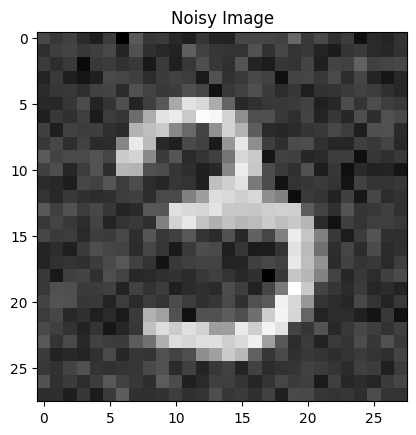

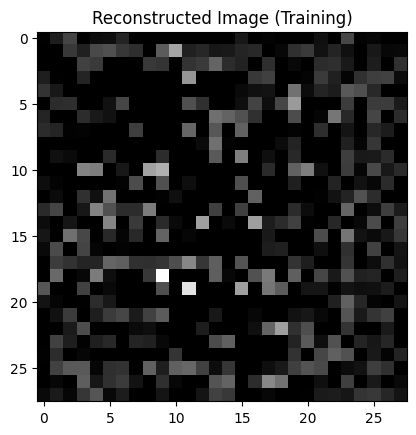

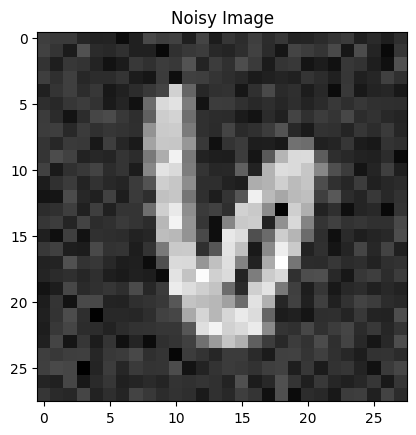

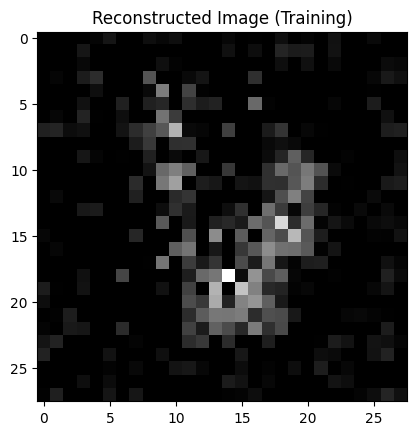

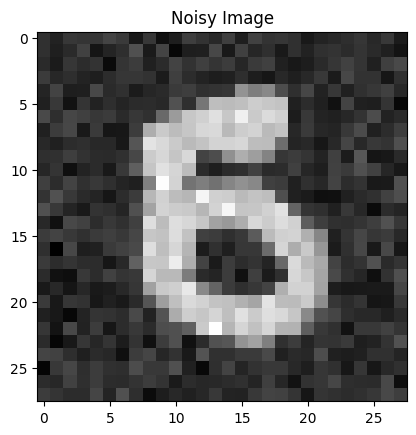

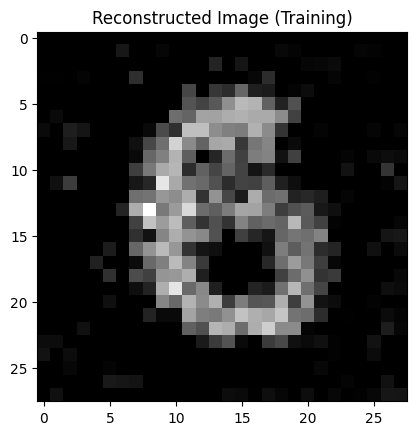

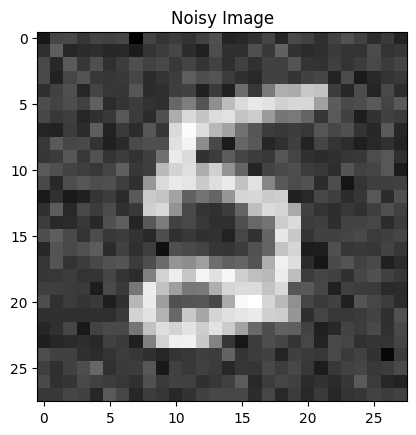

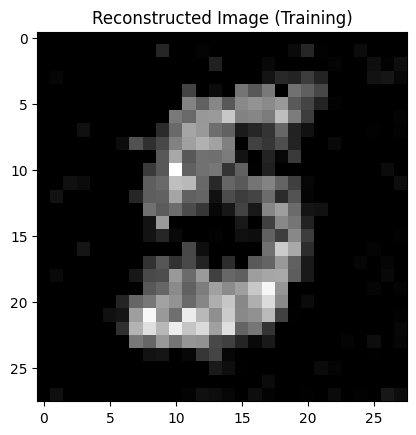

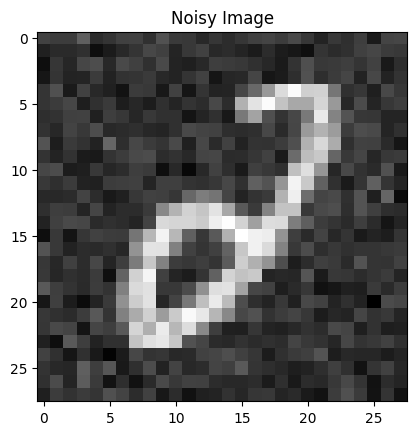

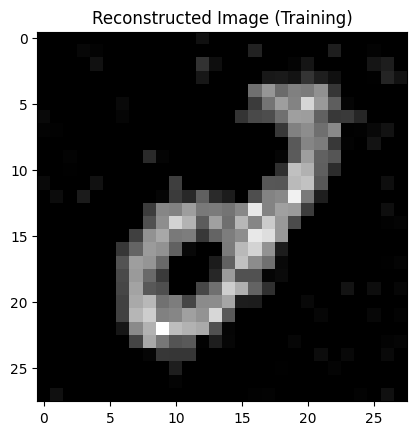

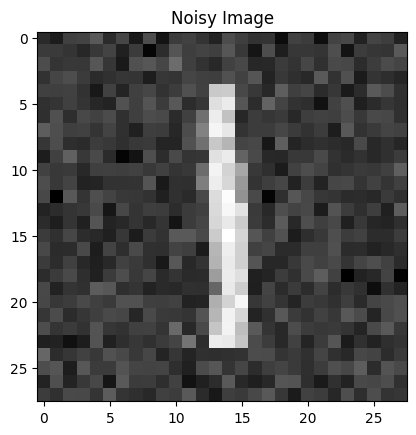

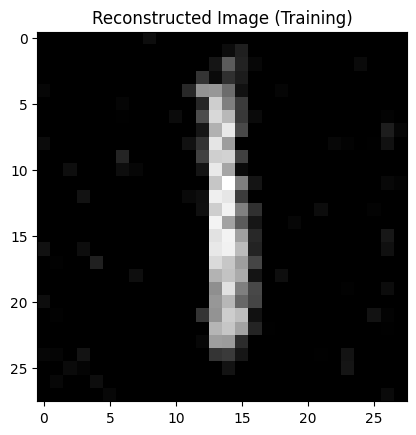

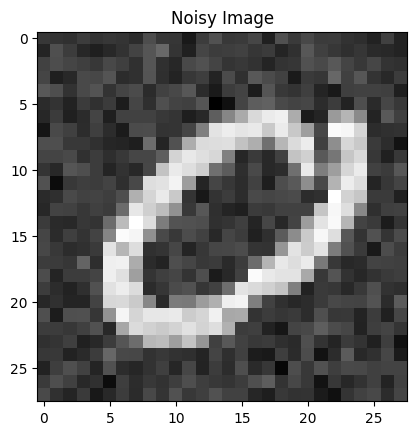

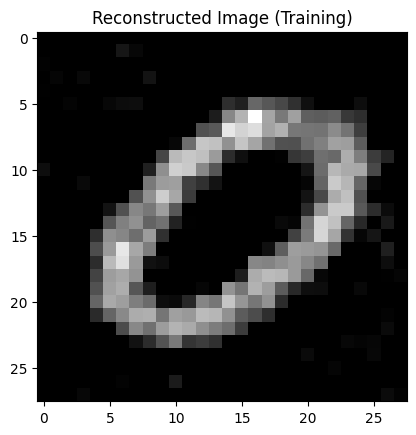

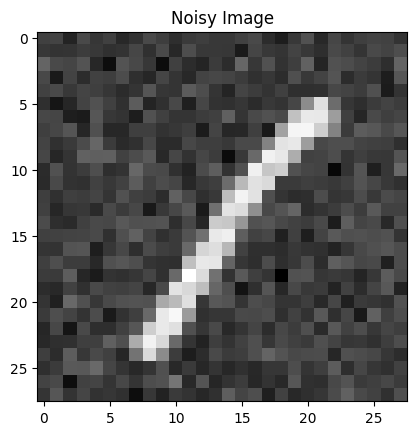

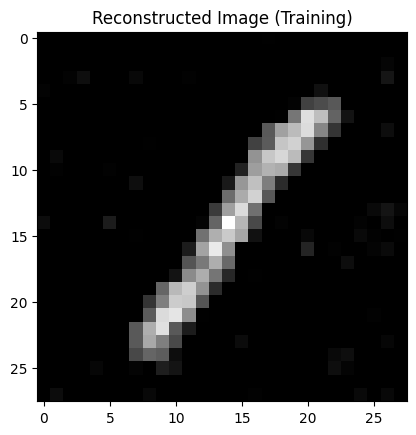

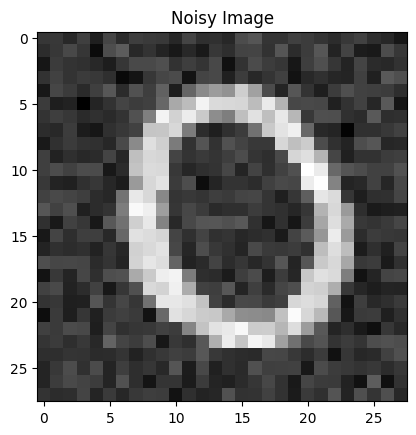

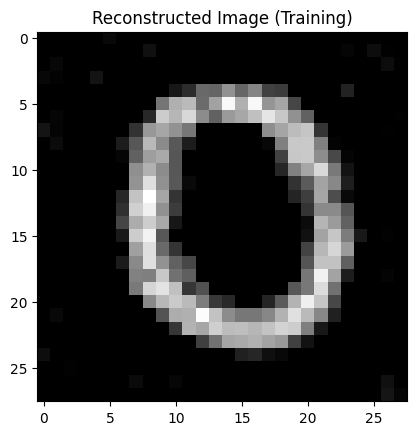

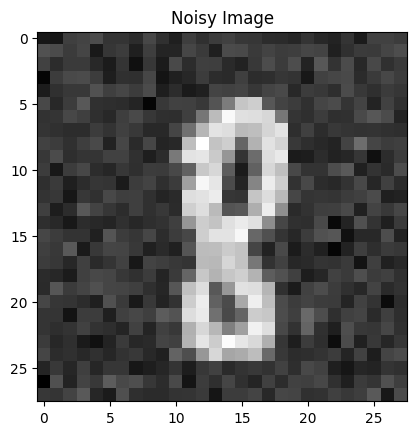

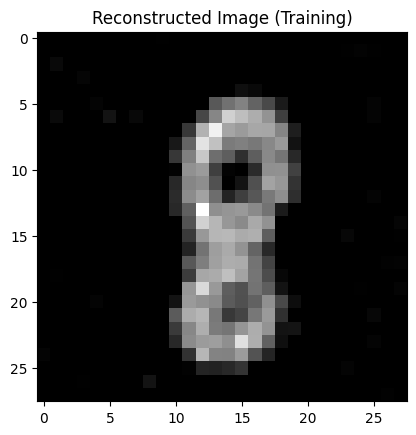

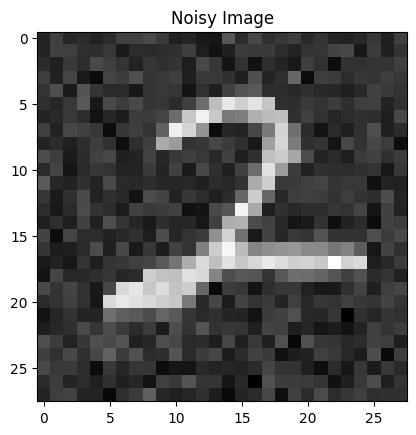

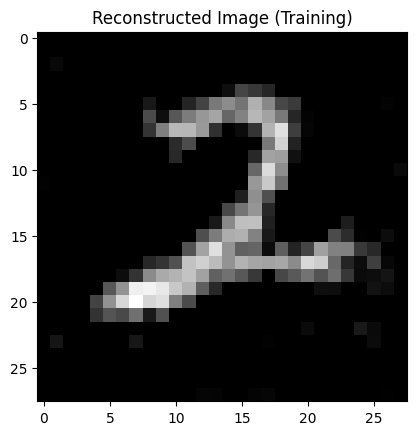

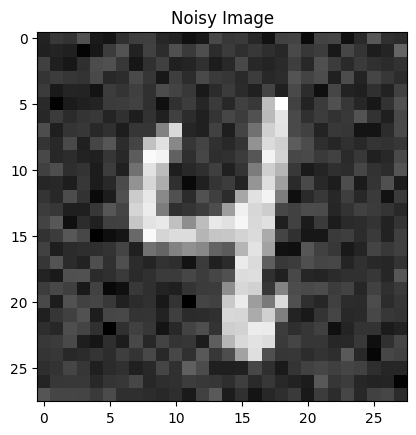

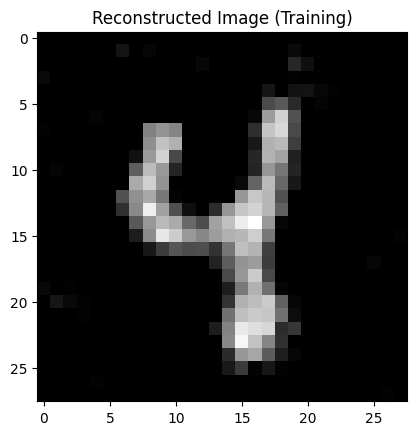

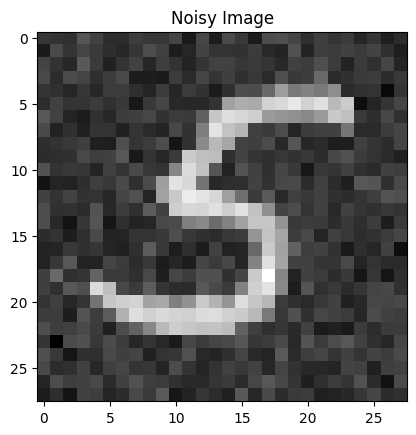

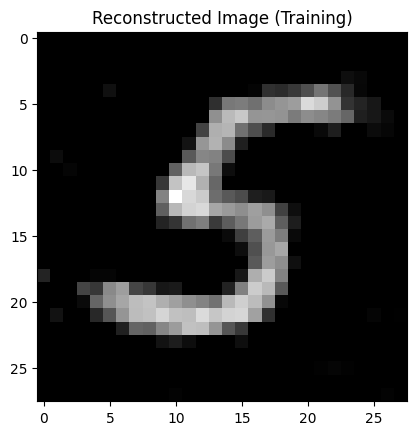

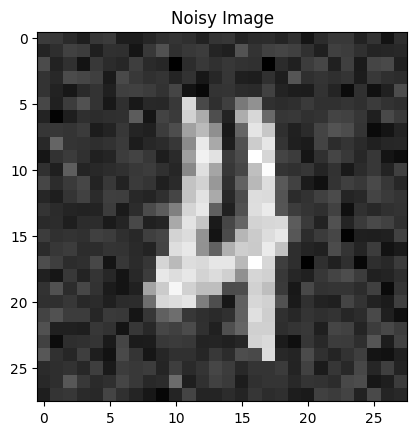

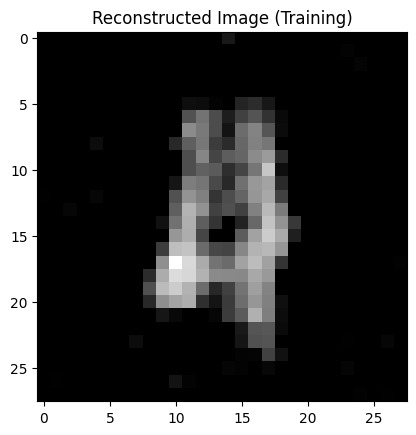

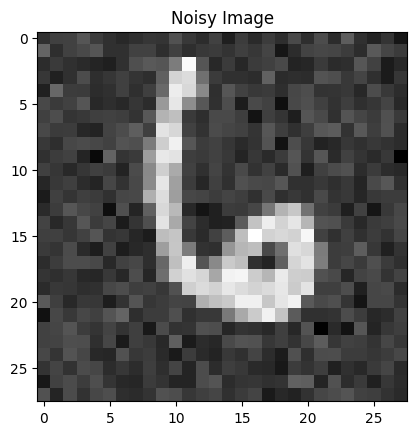

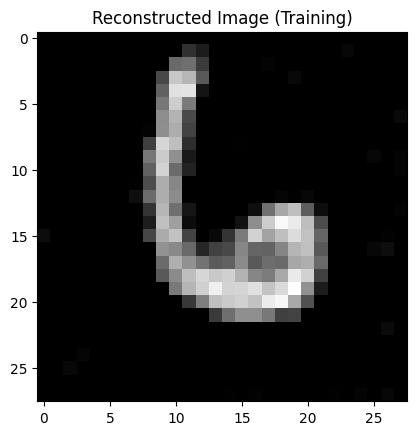

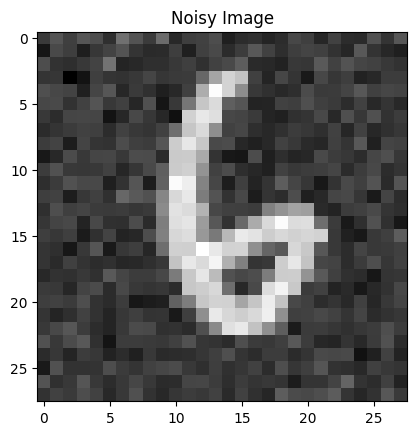

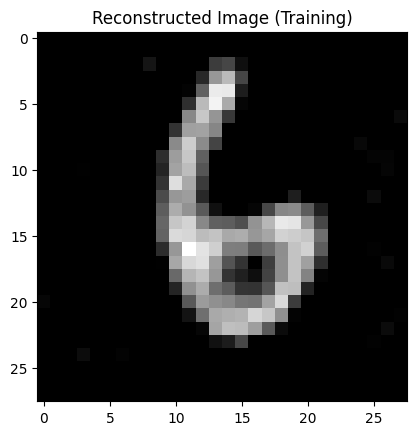

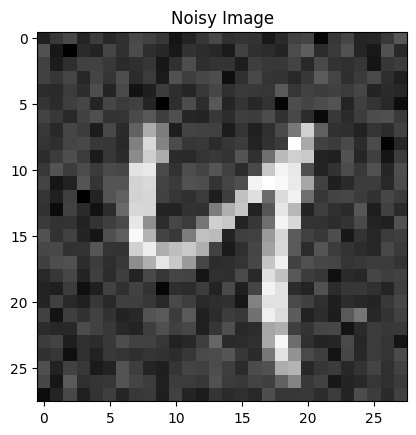

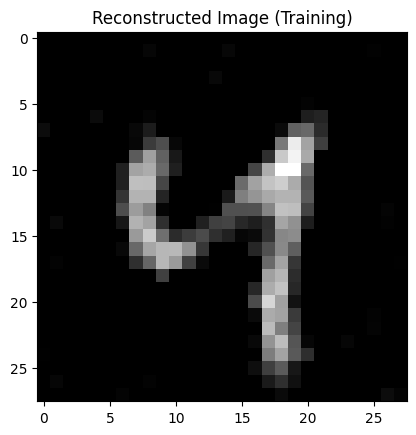

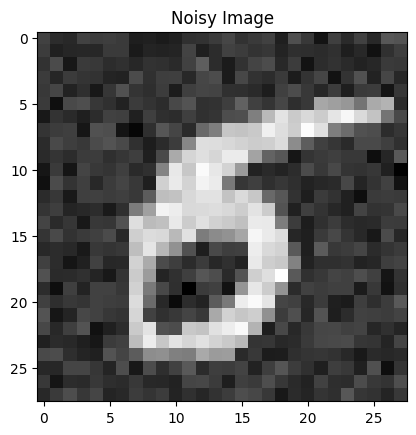

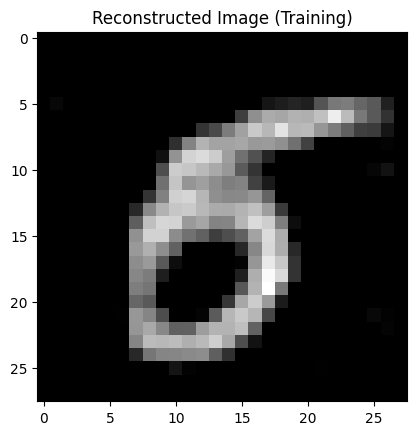

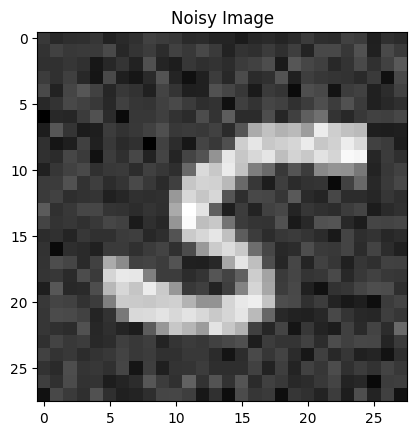

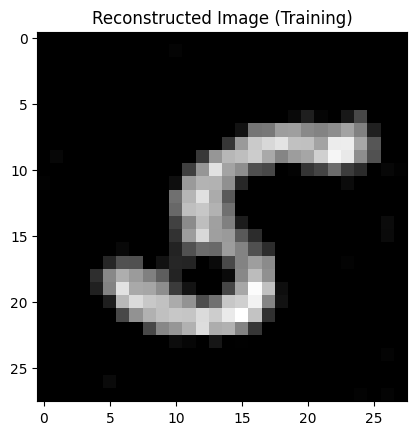

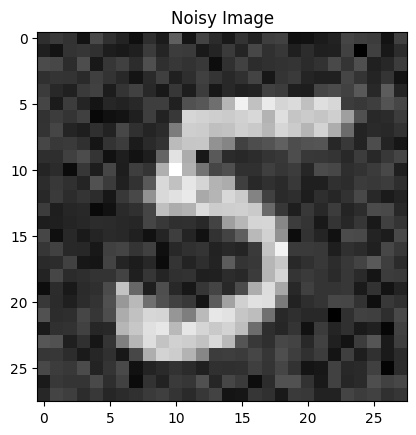

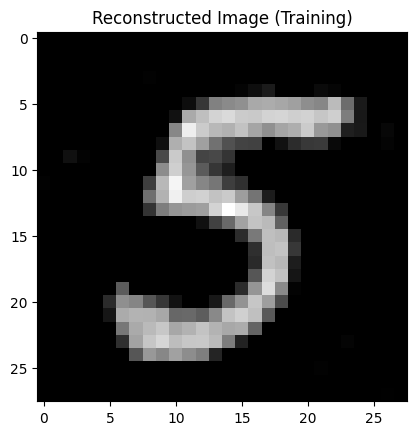

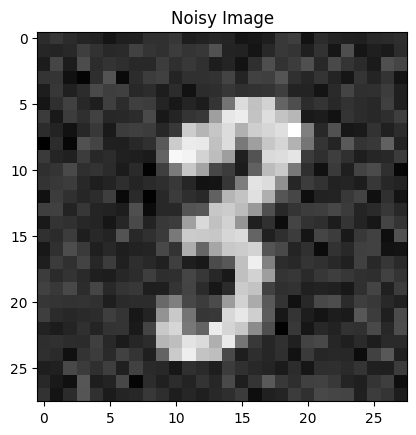

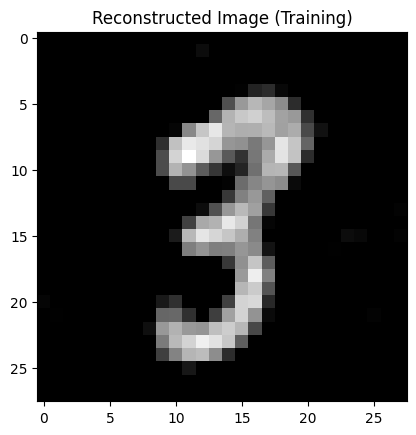

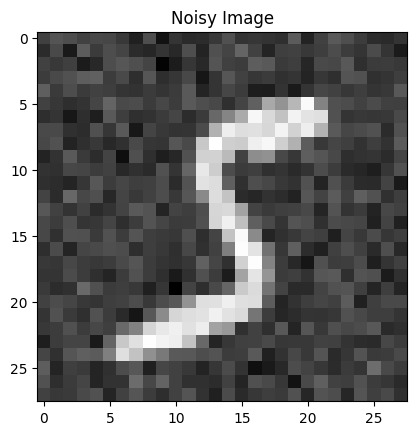

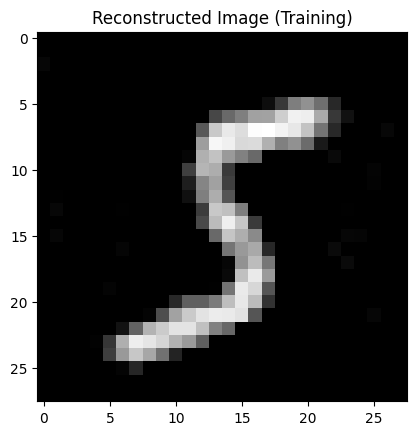

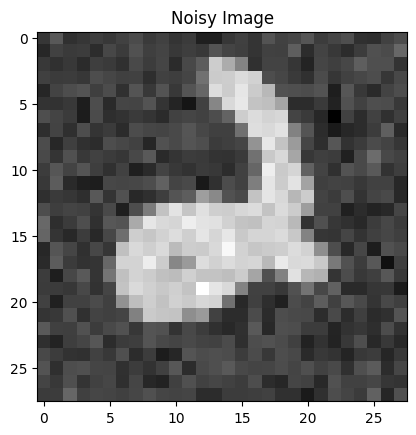

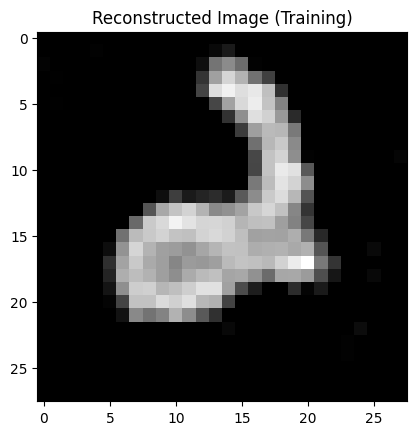

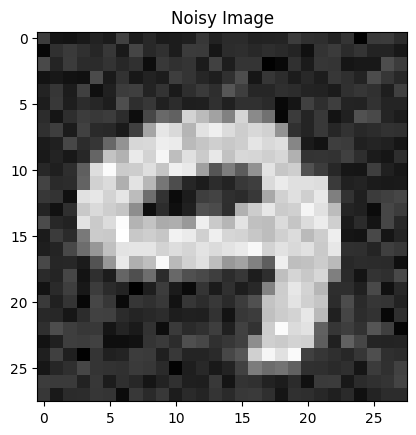

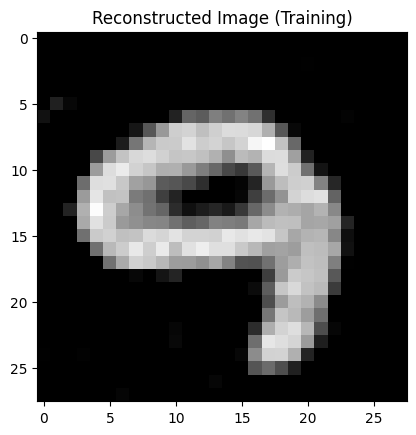

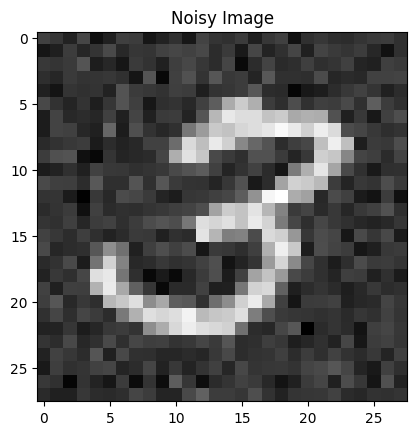

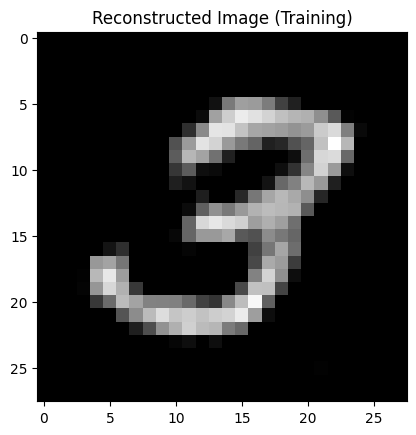

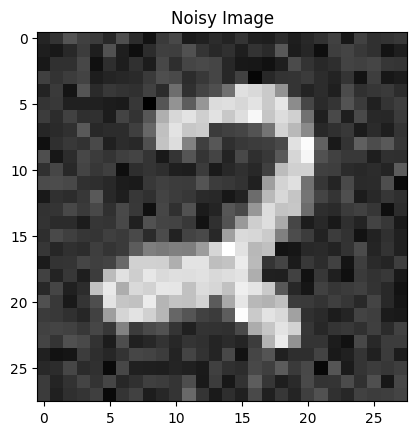

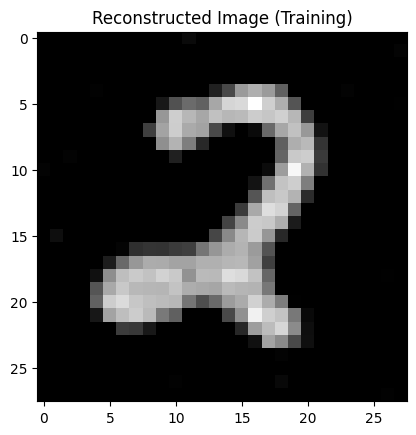

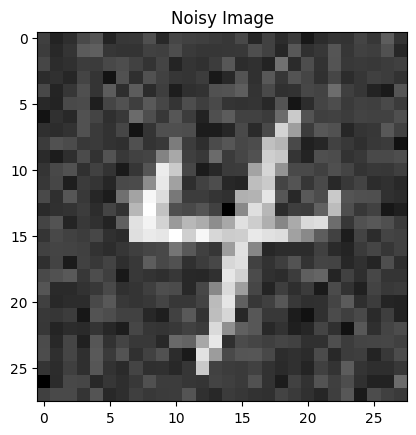

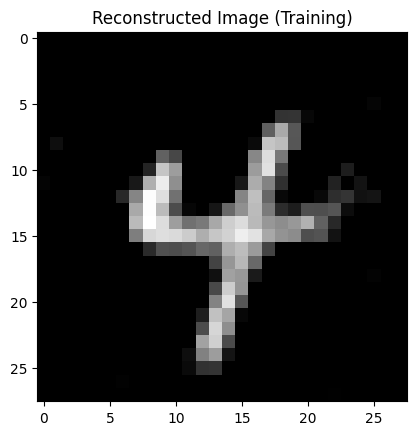

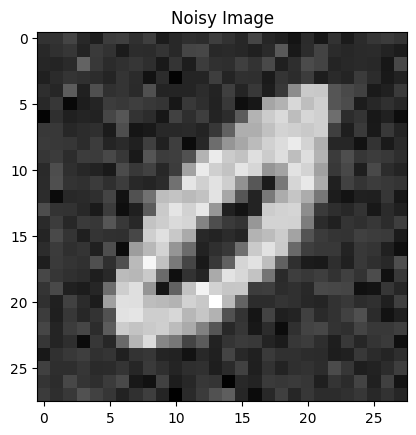

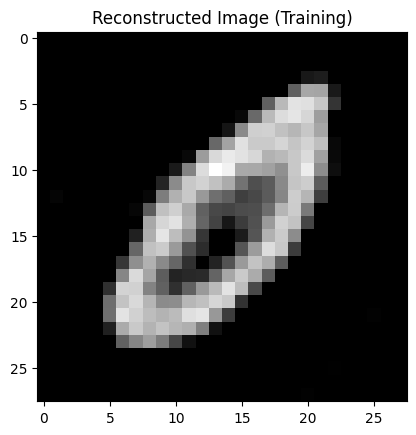

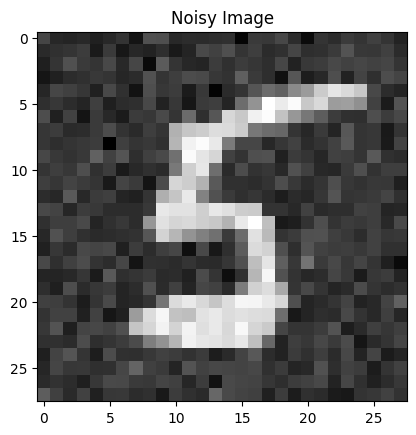

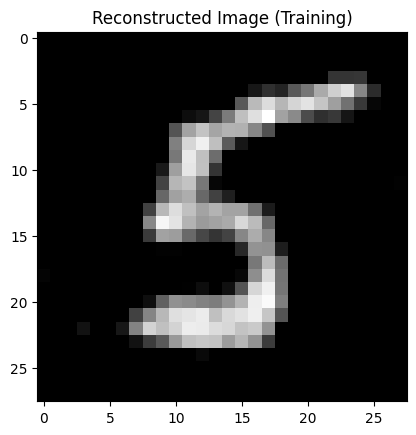

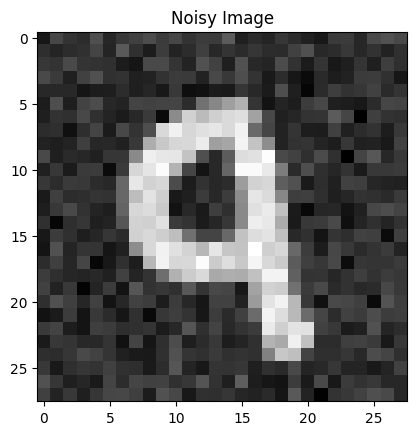

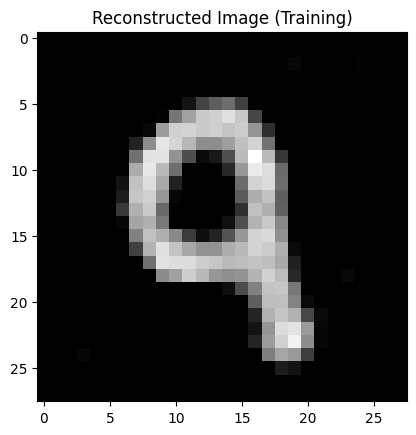

tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)


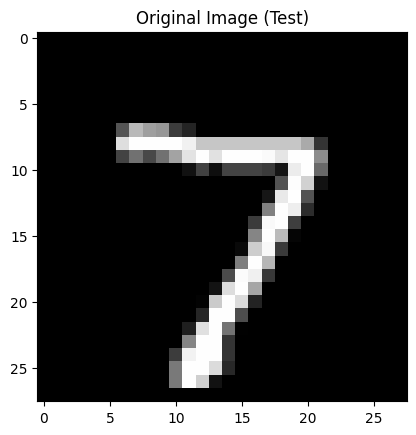

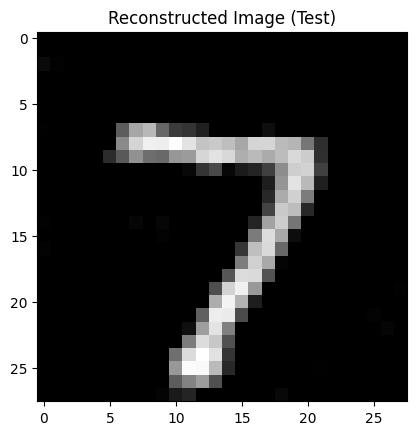

torch.Size([256, 28, 28])


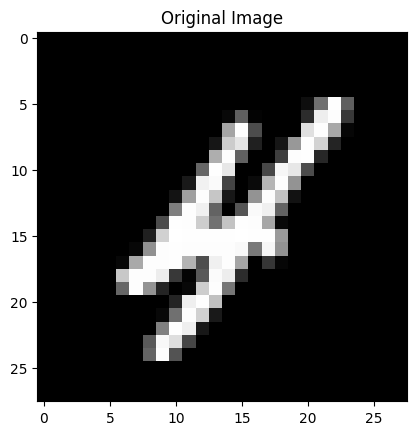

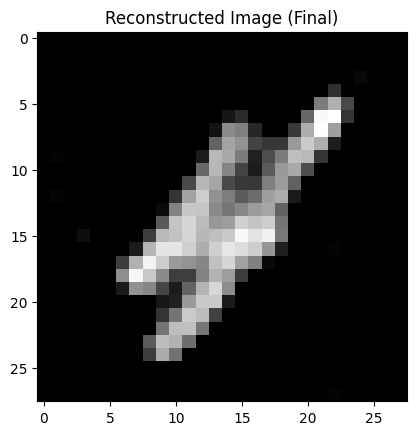

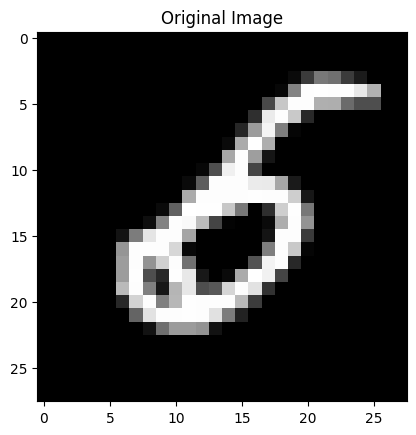

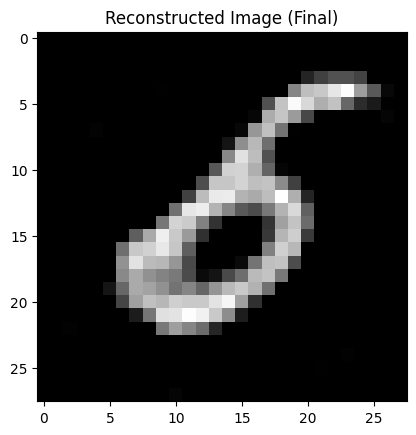

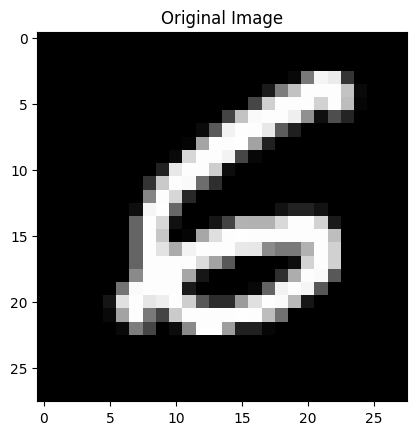

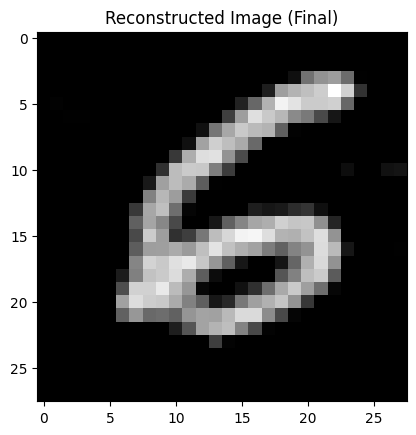

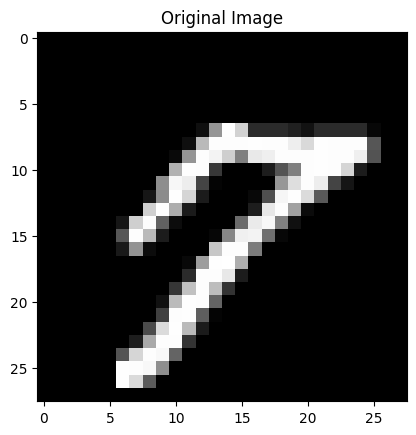

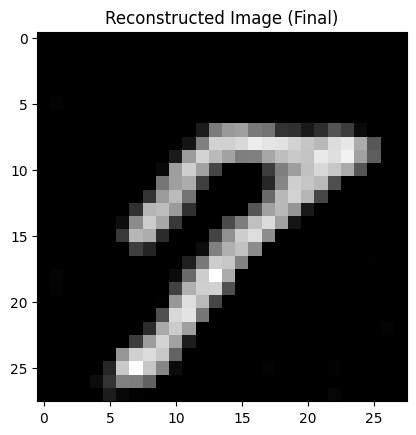

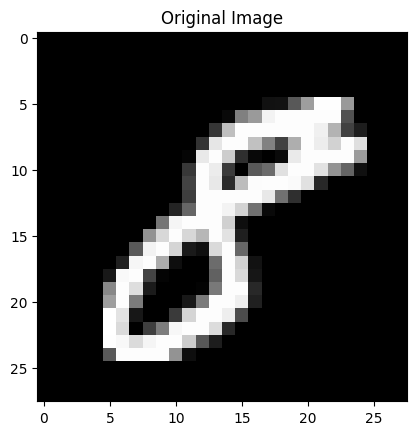

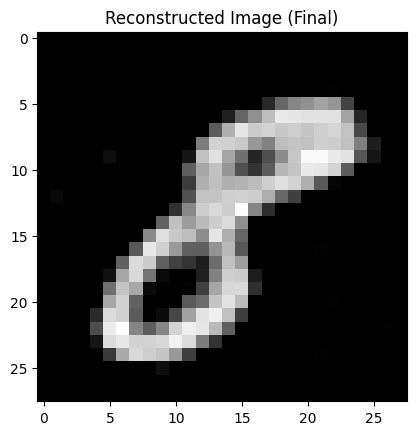

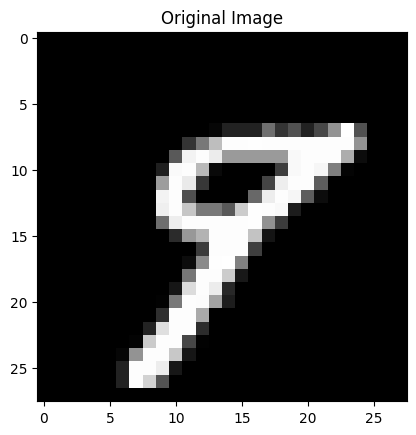

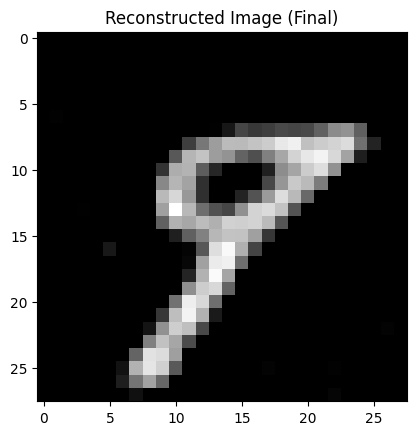

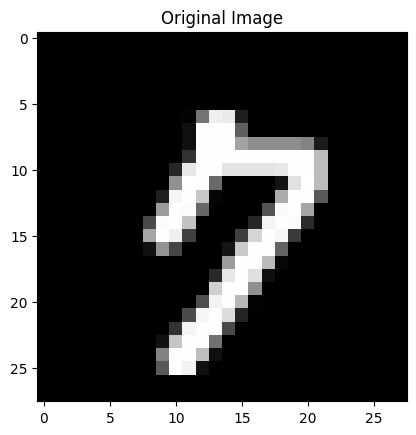

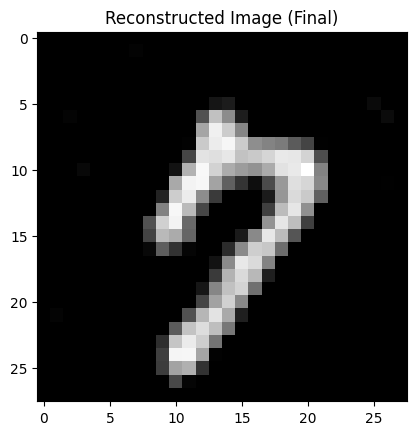

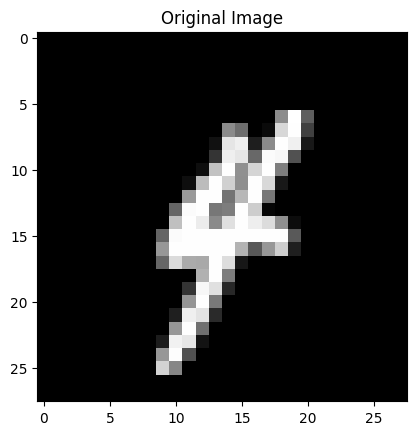

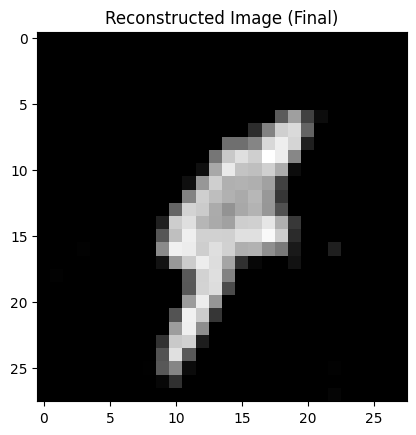

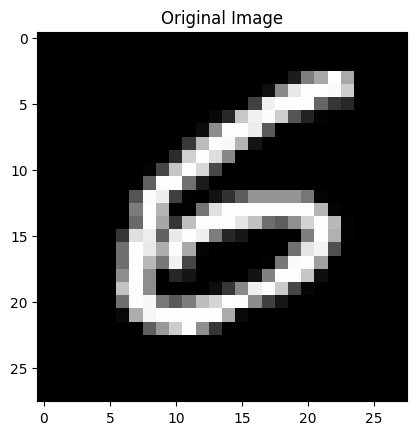

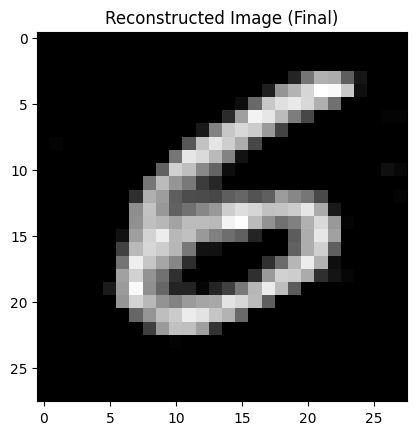

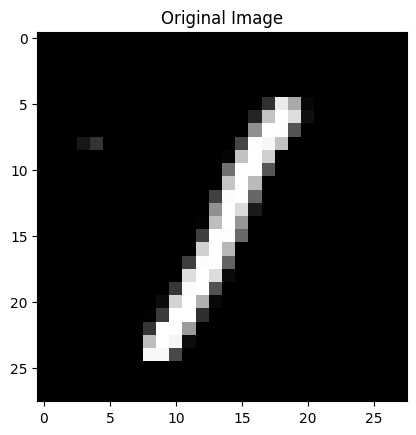

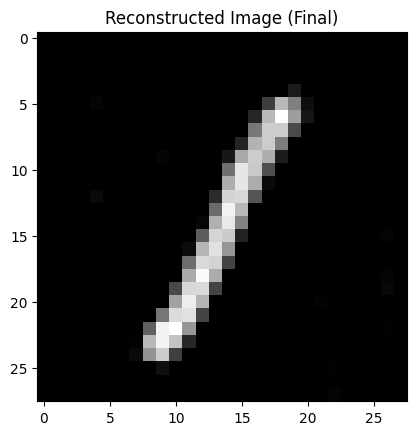

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 하이퍼 파라미터 지정
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 데이터 다운로드
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# DataLoader 설정
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# [합성곱] 모델 선언 - Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(batch_size, -1)
        return out


# [합성곱] 모델 선언 - Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 1, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        out = x.view(x.size(0), 64, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out


# 손실 함수, 최적화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# 훈련
for epoch in range(num_epoch):
    for i, [image, _] in enumerate(train_loader):
        # 입력 영상에 노이즈 추가
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28).to(device), 0, 0.1)
        image = image.to(device)
        image_noisy = image + noise

        optimizer.zero_grad()

        # Encoder와 Decoder에 입력 영상 및 노이즈 추가 영상 전달
        encoded = encoder(image_noisy)
        decoded = decoder(encoded)

        loss = loss_func(decoded, image)
        loss.backward()
        optimizer.step()

        # 일정 간격으로 결과 확인
        if i % 100 == 0:
            with torch.no_grad():
                # 훈련 중간 결과 확인
                encoded_test = encoder(image_noisy)
                decoded_test = decoder(encoded_test)

                plt.imshow(torch.squeeze(image_noisy[0]).cpu().numpy(), cmap='gray')
                plt.title('Noisy Image')
                plt.show()

                plt.imshow(torch.squeeze(decoded_test[0]).cpu().numpy(), cmap='gray')
                plt.title('Reconstructed Image (Training)')
                plt.show()

# 테스트
with torch.no_grad():
    for i, [image, _] in enumerate(test_loader):
        x = image.to(device)

        optimizer.zero_grad()
        encoded = encoder(x)
        decoded = decoder(encoded)

        # 테스트 중간 결과 확인
        if i % 1000 == 0:
            print(loss)

            plt.imshow(torch.squeeze(x[0]).cpu().numpy(), cmap='gray')
            plt.title('Original Image (Test)')
            plt.show()

            plt.imshow(torch.squeeze(decoded[0]).cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Image (Test)')
            plt.show()

# 최종 결과 확인
out_img = torch.squeeze(decoded.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.show()

    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.title('Reconstructed Image (Final)')
    plt.show()

